# Implementation of the SiPM response functions

This repository attempts to implement the SiPM low light response functions
described in [arXiv:1609.01181][sipm_response] in a python library to allow
for interfacing with the broader data analysis tools used by HEP. In this
notebook we will mainly break down the mathematical components that go into
the description given in the paper. There are tree components to the
`sipmpdf` package:

 - `functions`: Implementationg the sipm response functions as `numpy`/`tf`
   array comparible functions.
 - `generate`: methods for generating the sipm responses given a numpy random
   number generator.
 - `pdf`: methods for declaring the sipm response functions as a zfit-PDF
   object.

This documentation will follow the paper's arguments in presenting how the
functions are designed, and provide demonstrating functions

[sipm_response]: https://arxiv.org/pdf/1609.01181.pdf


In [1]:
import hist
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep
import numpy as np
import zfit

import sipmpdf

COLORS = mpl.rcParams["axes.prop_cycle"].by_key()["color"]

/home/ensc/.conda/envs/gantry_control/lib/python3.10/site-packages/zfit/__init__.py:63: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(


Here we will first define the parameters that enter the `zfit` method, along
with the true value used to generate the pseudo data. The meaning of each
term will be explain along the documentation. For deterministically
generating dummy responses using the example model, we also need to declare
the a numpy.default_rng instance

In [2]:
pedestal_t = 5.0
gain_t = 150.0
common_noise_t = 15.0
pixel_noise_t = 2.0
poisson_mean_t = 2.5
poisson_borel_t = 0.05
ap_beta_t = 100
ap_prob_t = 0.05
dc_prob_t = 0.01
dc_res_t = 5e-3
N_Events = 100_000

pedestal = zfit.Parameter("pedestal value", pedestal_t, -10, 50)
gain = zfit.Parameter("gain", gain_t, 100, 200)
common_noise = zfit.Parameter("common_noise", common_noise_t, 5, 25)
pixel_noise = zfit.Parameter("pixel_noise", pixel_noise_t, 1, 3)
poisson_mean = zfit.Parameter("poisson_mean", poisson_mean_t, 2, 3)
poisson_borel = zfit.Parameter("poisson_borel", poisson_borel_t, 0, 0.1)
ap_beta = zfit.Parameter("ap_beta", ap_beta_t, 20, 120)
ap_prob = zfit.Parameter("ap_prob", ap_prob_t, 0.0, 0.2)
dc_prob = zfit.Parameter("dc_prob", dc_prob_t, 0.0, 0.1)
dc_res = zfit.param.ConstantParameter("dc_res", dc_res_t)
obs = zfit.Space("x", limits=(-200, +1500))

rng = np.random.default_rng(seed=123_456_7890)

## The generalized Poisson distribution

The [Generalized Poisson distribution][gen_poisson] $GP(x;\mu,\lambda)$ is
used to model the probability of a number of primary discharges, or "number
of photoelectrons", that occur due to an incident light source. The
probability deviation from a simple Poisson distribution due to in-time
correlated discharges driven by optical crosstalk within the SiPM.

$$
GP(k=n_{p.e}; \mu, \lambda) = \frac{\mu(\mu + \lambda x)^{k-1}}{k!}\exp(-(\mu+\lambda x))
$$

This response can be though of a primary poisson process where each positive
result can also generate a branching poisson subprocess. Because of this, the
distribution will be wider than a simple poisson shifted up by from (1 + b)
factor. The function form of this method is defined as
`sipmpdf.functions.generalized_poisson`, while a corresponding random number
generator will be given in `sipmpdf.generate.generate_genpoisson`.

[gen_poisson]: https://www.jstor.org/stable/1267389


Text(0, 0.5, 'Number of events')

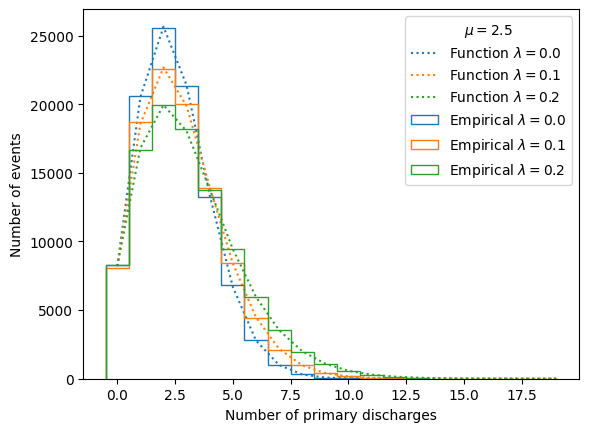

In [3]:
n = np.arange(20)
for idx, borel in enumerate([0.0, 0.1, 0.2]):
    plt.plot(
        n,
        sipmpdf.functions.generalized_poisson(n, poisson_mean_t, borel) * N_Events,
        label=f"Function $\lambda={borel}$",
        color=COLORS[idx],
        ls="dotted",
    )


for idx, borel in enumerate([0.0, 0.1, 0.2]):
    plt.hist(
        sipmpdf.generate.generate_genpoisson(
            size=N_Events, poisson_mean=poisson_mean_t, poisson_borel=borel, rng=rng
        ),
        bins=np.arange(15) - 0.5,
        color=COLORS[idx],
        histtype="step",
        ls="solid",
        label=f"Empirical $\lambda={borel}$",
    )
plt.legend(title=f"$\mu={poisson_mean_t:.1f}$")
plt.xlabel("Number of primary discharges")
plt.ylabel("Number of events")

## A Gaussian smeared General Poisson distribution

The simplest response model that excludes other nonlinear effects other than
cross talk, would that each of the $n_{p.e}$ discharges is scaled by the gain
factor $g$, and also subject to noise effects. Aside from the common noise
$\sigma_0$, the apparent noise will also be impacted by the $n_{p.e}$, as there
are also per-pixel variation in the system, which we will notate as $\sigma_1$.
Overall, this results the convolution of the General Poisson distribution
smeared by a Gaussian noise. The PDF of this model is given as:

$$
P(x; p, g, \mu, \lambda, \sigma_0, \sigma_1) =
\sum_{n_{p.e}=0}^{\infty} GP(n_{p.e};\mu,\lambda) \cdot
N(x; p + n_{p.e} g, \sigma(n_{p.e}))
$$

Where $GP$ is the general Poisson distribution (shown previously), and $N(x;
\mu,\sigma)$ is the Gaussian distribution a mean value $m$ and standard
deviation $\sigma$. The value $p$ notates the pedestal shift (constant offset)
of the readout system from the apparent 0 point, and $\sigma(n)$ is used to
calculate the varying noise factor arising from pixel variation noise $\sigma(n)
= \sqrt{\sigma_0^2 + n\sigma_p^2}$. For demonstration let us plot this model
that has already been implemented in the `sipmpdf.functions`, as well as the
pseudo data generated using the correponding method in the `sipmpdf.generate`
module.


0.05


Text(30, 0.000630828867285034, '')

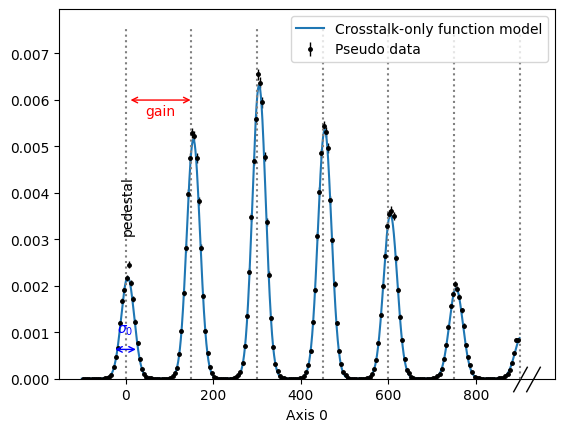

In [4]:
# Generated psuedo data
h = hist.Hist(hist.axis.Regular(200, -100, 900))
response = sipmpdf.generate.generate_response_no_dark_no_ap(
    size=N_Events,
    pedestal=pedestal_t,
    gain=gain_t,
    common_noise=common_noise_t,
    pixel_noise=pixel_noise_t,
    poisson_mean=poisson_mean_t,
    poisson_borel=poisson_borel_t,
    rng=rng,
)
h.fill(response)
mplhep.histplot(
    h, density=True, label="Pseudo data", histtype="errorbar", color="k", markersize=5
)

x = np.linspace(-100, 900, 2000)
y = sipmpdf.functions.sipm_response_no_dark_no_ap(
    x,
    pedestal=pedestal_t,
    gain=gain_t,
    common_noise=common_noise_t,
    pixel_noise=pixel_noise_t,
    poisson_mean=poisson_mean_t,
    poisson_borel=poisson_borel_t,
)
plt.plot(x, y, label=f"Crosstalk-only function model")


ymax = np.max(y)
plt.legend()
plt.vlines(
    gain_t * np.arange(7),
    ymin=0,
    ymax=np.max(y) * 1.2,
    color="gray",
    linestyles="dotted",
)
plt.annotate("pedestal", [pedestal_t, ymax * 0.5], rotation=90, ha="center")
plt.annotate("gain", [pedestal_t + gain_t / 2, ymax * 0.9], ha="center", color="red")
plt.annotate(
    "",
    xy=(pedestal_t, ymax * 0.95),
    xytext=(pedestal_t + gain_t, ymax * 0.95),
    arrowprops=dict(arrowstyle="<->", color="red"),
)

plt.annotate("$\sigma_0$", [0, 0.001], ha="center", color="blue")
plt.annotate(
    "",
    xy=(-30, ymax * 0.1),
    xytext=(30, ymax * 0.1),
    arrowprops=dict(arrowstyle="<->", color="blue"),
)

A corresponding PDF is implements as `sipmpdf.pdf.SiPMResponse_NoDarkNoAP_PDF`
class. Which we can initialize with the variable declared at the start of the
notebook. (All fitting routines will use a binned fit to save compute time in
this demonstration). The following is a simple fit routine.

/home/ensc/.conda/envs/gantry_control/lib/python3.10/site-packages/zfit/minimizers/fitresult.py:1204: ChangedFeatureWarning: The behavior of this functionality recently changed.To turn this warning off, use `zfit.settings.changed_warnings.hesse_name = False`  or 'all' with `zfit.settings.changed_warnings.all = False
Default name of hesse (which is currently the method name such as `minuit_hesse`or `hesse_np`) has changed to `hesse` (it still adds the old one as well. This will be removed in the future). INSTRUCTIONS: to stay compatible,  change wherever you access the error to 'hesse' (if you don't explicitly specify the name in hesse(...).
  warn_changed_feature(message, "hesse_name")


FitResult of
<BinnedNLL model=[<zfit.models.tobinned.BinnedFromUnbinnedPDF object at 0x79e6487c0610>] data=[<zfit._data.binneddatav1.BinnedData object at 0x79e6490afac0>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | internal) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════════╡
│  True   │    True     │      False       │ 5.2e-11 │               918.23 |  954.5688 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════════╛

Parameters
name              value  (rounded)        hesse    at limit
--------------  ------------------  -----------  ----------
pedestal value              5.0215  +/-   0.089       False
gain                       149.991  +/-   0.029       False
common_noise               15.0324  +/-   0.065       False
pixel_noise       

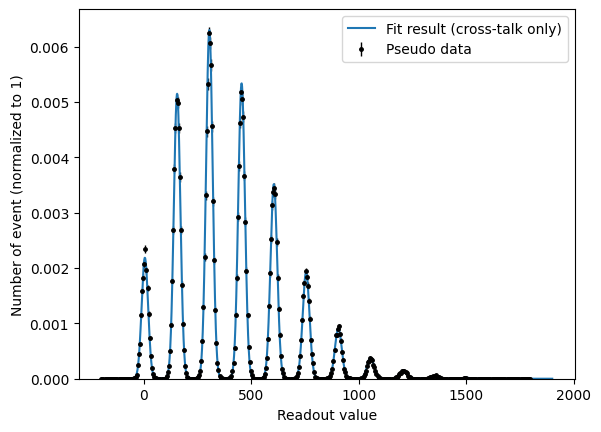

In [5]:
# Declaring the binned phase space in PDF
binning = zfit.binned.RegularBinning(400, -200, 1800, name="x")
obs_bin = zfit.Space("x", binning=binning)

# Creating the binned/unbiined PDF object (unbinned for plotting)
pdf_unbinned = sipmpdf.pdf.SiPMResponse_NoDarkNoAP_PDF(
    obs=obs,
    pedestal=pedestal,
    gain=gain,
    common_noise=common_noise,
    pixel_noise=pixel_noise,
    poisson_mean=poisson_mean,
    poisson_borel=poisson_borel,
)
pdf_bin = zfit.pdf.BinnedFromUnbinnedPDF(
    pdf_unbinned,
    obs_bin,
)

# Constructing binned data
data_unbinned = zfit.Data.from_numpy(obs=obs, array=response)
data_bin = data_unbinned.to_binned(obs_bin)

# Running the fit
nll_bin = zfit.loss.BinnedNLL(pdf_bin, data_bin)
minimizer = zfit.minimize.Minuit()
result = minimizer.minimize(nll_bin)
result.hesse()
print(result)
# Plotting the results
h = data_bin.to_hist()  # Converting to a histogram container
x = np.linspace(-100, 1900, 2000)
y = zfit.run(pdf_unbinned.pdf(x))

mplhep.histplot(
    h, density=True, label="Pseudo data", histtype="errorbar", color="k", markersize=5
)
plt.plot(x, y, label="Fit result (cross-talk only)")
plt.xlabel("Readout value")
plt.ylabel("Number of event (normalized to 1)")
plt.legend()

## Afterpulse response

For $k$ pixels undergoing primary discharges, each discharged pixel has a
probability $P_{a.p}$ of undergoing afterpulsing. The contribution of
afterpulsing to the readout is modeled using a simple exponential model
extending above the primary discharge, with the afterpulse factor $\beta$:

$$A_{a.p.}(x;n_{a,p}=1,\beta)=\frac{1}{\beta}\exp\left(-\frac{x}{\beta}\right); \quad (x>0)$$

Note: The [source paper](https://arxiv.org/pdf/1609.01181.pdf) for these
equations uses $i$ in place of $n_{a.p.}$. We used the second option for
improved readability

Here $x$ is the additional contribution of the afterpulse above the primary
discharge. Contributions from multiple afterpulses can also be modelled by the
analytic convolution of the multiple exponential distributions:

$$
A_{a.p.}(x;n_{a.p.},\beta)
=\otimes_1^{n_{a.p.}}A_{a.p.}(x;n_{a.p.}=1,\beta)
=\frac{x^{(n_{a.p.}-1)}}{(n_{a.p.}-1)!\beta^{n_{a.p.}}}\exp\left(-\frac{x}{\beta}\right); \quad (x>0)
$$

While the total contribution of the primary discharge and the variable
afterpulsing should be subject to noise and gain variations in the system,
$A(x; n_{a.p.},\beta,\sigma)$, the convolution of the exponential distribution
with a normal distribution, does not have a simple analytic form. Instead, for
multiple afterpulse contributions, we work under the assumption that the
exponential factor $\beta$ of the afterpulse is generally larger than the noise
factor $\sigma_0$. For number of afterpulses $n_{a.p.}>1$ the afterpulse
contribution distribution is sufficiently smooth such that additional
convolution with the noise factor is not needed i.e.
$A(x;n_{a.p.}>1,\beta,\sigma)\sim A(x;n_{a.p.}>1,\beta)$.

For $n_{a.p.}=1$, we use the approximation:

$$
A_{a.p.}(x;n_{a.p.}=1,\beta,\sigma)
= A_{a.p.}(x;n_{a.p.}=1,\beta) \otimes G(x;\sigma)
\sim \frac{1}{2\beta} \exp\left(-\frac{x}{\beta}\right)\left(1+\mathrm{erf}\left(\frac{x}{\sigma_k \sqrt{2}}\right)\right)
$$

Concrete approximate distrubtion function are implemented as
`sipmpdf.functions.ap_reponse_smeared`, while the full randomized generating
function can also be found in `sipmpdf.generate.generate_ap_response_smeared`.

The following plot is an example of afterpulsing contributions with various
values of $n_{a.p.}$.


/home/ensc/Homework/UMDCMS/SiPMCalib/sipmpdf/src/sipmpdf/functions.py:215: RuntimeWarning: invalid value encountered in log
  kern.log(kern.power(x, n_ap - 1))
/home/ensc/Homework/UMDCMS/SiPMCalib/sipmpdf/src/sipmpdf/functions.py:215: RuntimeWarning: invalid value encountered in log
  kern.log(kern.power(x, n_ap - 1))


Text(0, 0.5, 'Number of Events (Normalized to 1)')

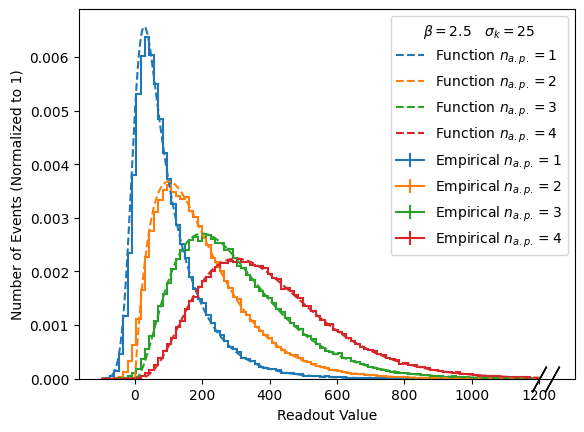

In [6]:
x = np.linspace(-100, 1200, 2000)

for idx, n_ap in enumerate(np.arange(1, 5)):
    y = sipmpdf.functions.ap_response_smeared(x=x, smear=25, n_ap=n_ap, beta=100)
    plt.plot(
        x, y, label=f"Function $n_{{a.p.}}={n_ap}$", color=COLORS[idx], ls="dashed"
    )

    h = hist.Hist(hist.axis.Regular(100, -100, 1200))
    r = rng.exponential(scale=100, size=(N_Events, n_ap))
    r = np.sum(r, axis=-1) + rng.normal(loc=0, scale=25, size=N_Events)
    h.fill(r)

    mplhep.histplot(
        h,
        density=True,
        label=f"Empirical $n_{{a.p.}}={n_ap}$",
        histtype="step",
        yerr=0,
        color=COLORS[idx],
    )

plt.legend(title=r"$\beta=2.5\quad\sigma_k=25$")
plt.xlabel("Readout Value")
plt.ylabel("Number of Events (Normalized to 1)")

The impact of afterpulsing on the readout spectrum is that the primary discharge
peak has additional non-Gaussian smearing from probabilistic contributions from
afterpulsing. The degree by which this smearing occurs also depends on the
number of primary discharges that occur, as that also determines the number of
afterpulses that can occur. The function form of this smearing can be
analytically expressed using the Binomial probability of $n_{a.p.}$ occuring
given $k$ primary discharges $B(n_{a.p.};k,P_{a.p.})$.

$$B(0;k,P_{a.p.})G(x-kg,\sigma(k))+\sum_{n_{a.p.}=1}^k B(n_{a.p.};k,P_{a.p.})A(x-kg;n_{a.p.},\beta,\sigma(k))$$


Putting this together with the General Poisson distribution for the number of
the primary discharges that can occur, we arrive at another semi-realistic
response model:

$$
GP(0;\mu,\lambda)G(x;p,\sigma_0) +
\sum_{k=1}GP(k;\mu,\lambda) \left(
             B(0;k,P_{a.p.})G(x;p+kg,\sigma_k)
             +\sum_{n_{a.p.}=1}^{10} B(n_{a.p.};k,P_{a.p.})A(x;n_{a.p.},k,\beta)\right
         )
$$

The cut of at $n_{a.p}=10$ is used to reduce the number of calculations, since
$P_{a.p}$ is expected to be small, and we are also expecting $k$ is also
expected to be small.

This function is implemented as `sipmpdf.functions.sipm_response_no_dark`, and
corresponding generator `sipmpdf.generate.generate_reponse_no_dark`.


/home/ensc/Homework/UMDCMS/SiPMCalib/sipmpdf/src/sipmpdf/functions.py:215: RuntimeWarning: invalid value encountered in log
  kern.log(kern.power(x, n_ap - 1))


Text(30, 0.0005830616166522289, '')

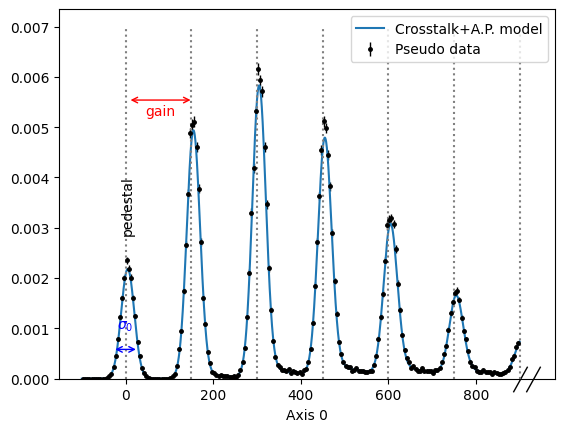

In [7]:
# Generated psuedo data
h = hist.Hist(hist.axis.Regular(200, -100, 900))
response = sipmpdf.generate.generate_response_no_dark(
    size=N_Events,
    pedestal=pedestal_t,
    gain=gain_t,
    common_noise=common_noise_t,
    pixel_noise=pixel_noise_t,
    poisson_mean=poisson_mean_t,
    poisson_borel=poisson_borel_t,
    ap_prob=ap_prob_t,
    ap_beta=ap_beta_t,
    rng=rng,
)
h.fill(response)
mplhep.histplot(
    h, density=True, label="Pseudo data", histtype="errorbar", color="k", markersize=5
)

x = np.linspace(-100, 900, 2000)
y = sipmpdf.functions.sipm_response_no_dark(
    x,
    pedestal=pedestal_t,
    gain=gain_t,
    common_noise=common_noise_t,
    pixel_noise=pixel_noise_t,
    poisson_mean=poisson_mean_t,
    poisson_borel=poisson_borel_t,
    ap_prob=ap_prob_t,
    ap_beta=ap_beta_t,
)
plt.plot(x, y, label=f"Crosstalk+A.P. model")


ymax = np.max(y)
plt.legend()
plt.vlines(
    gain_t * np.arange(7),
    ymin=0,
    ymax=np.max(y) * 1.2,
    color="gray",
    linestyles="dotted",
)
plt.annotate("pedestal", [pedestal_t, ymax * 0.5], rotation=90, ha="center")
plt.annotate("gain", [pedestal_t + gain_t / 2, ymax * 0.9], ha="center", color="red")
plt.annotate(
    "",
    xy=(pedestal_t, ymax * 0.95),
    xytext=(pedestal_t + gain_t, ymax * 0.95),
    arrowprops=dict(arrowstyle="<->", color="red"),
)

plt.annotate("$\sigma_0$", [0, 0.001], ha="center", color="blue")
plt.annotate(
    "",
    xy=(-30, ymax * 0.1),
    xytext=(30, ymax * 0.1),
    arrowprops=dict(arrowstyle="<->", color="blue"),
)

Next let us attempt to fit the psuedo data to the model function. This PDF is
already provided in the `sipmpdf.pdf` module as `SiPMResponse_NoDC_PDF`. We will
be running the same binned fitting routine as with the example PDF previously.


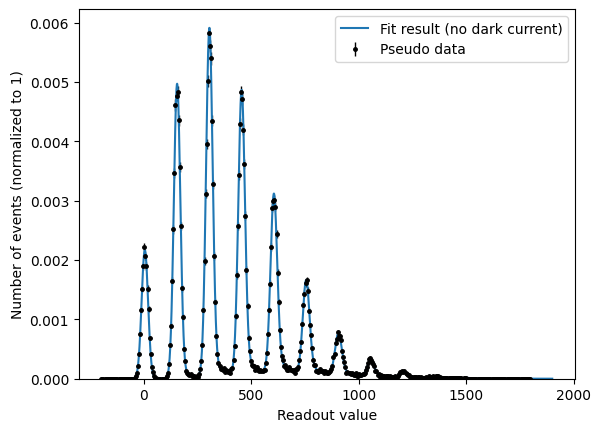

In [8]:
# Create pdf for the response with no dark current
pdf = sipmpdf.pdf.SiPMResponse_NoDC_PDF(
    obs=obs,
    pedestal=pedestal,
    gain=gain,
    common_noise=common_noise,
    pixel_noise=pixel_noise,
    poisson_mean=poisson_mean,
    poisson_borel=poisson_borel,
    ap_beta=ap_beta,
    ap_prob=ap_prob,
)
pdf_bin = zfit.pdf.BinnedFromUnbinnedPDF(pdf, obs_bin)

# Making the data container
data_unbinned = zfit.Data.from_numpy(obs=obs, array=response)
data_bin = data_unbinned.to_binned(obs_bin)

# Running the fit
nll_bin = zfit.loss.BinnedNLL(pdf_bin, data_bin)
minimizer = zfit.minimize.Minuit()
result = minimizer.minimize(nll_bin)
result.hesse()
result

h = data_bin.to_hist()  # Converting to a histogram container
x = np.linspace(-100, 1900, 2000)
y = zfit.run(pdf.pdf(x))

ax = mplhep.histplot(
    h, density=True, label="Pseudo data", histtype="errorbar", color="k", markersize=5
)
plt.plot(x, y, label="Fit result (no dark current)")
plt.xlabel("Readout value")
plt.ylabel("Number of events (normalized to 1)")
plt.legend()

## Dark Current Response

Dark current is described as random discharge uncorrelated with the trigger
used to defined the current the data collection window. The model of this is
evaluated in the paper as:

$$
D(x)=\frac{1}{2 \log(\frac{g}{\epsilon})}\left(\frac{1}{x-p}+\frac{1}{p+g-x} \right)\;;\quad
(p+\epsilon g<x < p + (1-\epsilon) g)
$$

Where $\epsilon$ is the resolution factor of the data collection relative to the
discharge peak shape. A numerical convolution of this function with a normal
distribution with be implemented in the model to account for electrical noise.
Given the sharp features of $D(x)$, the limitations of numerical convolution are
why the function appears "noisy". The generation of this distribution using can
be simulated by a by wandering peak in the window, which we provide as the
`generate.generate_dark_current_contrib`, which does not include the Gaussian
smoothing process.

Text(0, 0.5, 'Number of events (normalized to 1)')

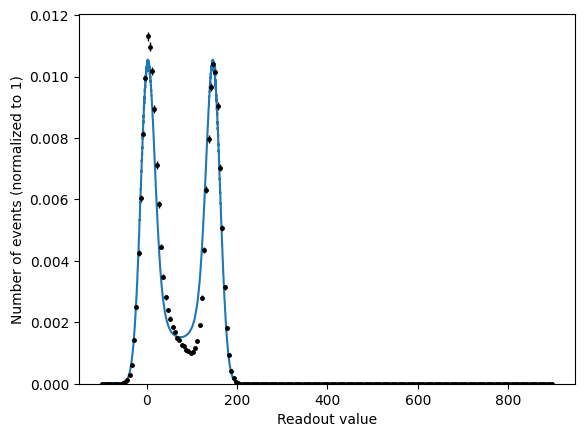

In [9]:
x = np.linspace(-100, 300, 2000)
dc = sipmpdf.functions.darkcurrent_response_smeared(
    x=x, smear=common_noise_t, gain=gain_t, resolution=1e-4
)


h = hist.Hist(hist.axis.Regular(200, -100, 900))
response = sipmpdf.generate.generate_dark_current_contrib(
    size=N_Events,
    gain=gain_t,
    ratio=4,
    rng=rng,
)
h.fill(rng.normal(loc=response, scale=common_noise_t))
mplhep.histplot(
    h, density=True, label="Pseudo data", histtype="errorbar", color="k", markersize=5
)

plt.plot(x, dc, label="Dark Current Response Smeared")
plt.xlabel("Readout value")
plt.ylabel("Number of events (normalized to 1)")

Adding dark current contributions to events where there were no time-correlated
discharges, we arrive at the full model of the SiPM Response:

$$
GP(0;\mu,\lambda) \left(
           (1-P_{d.c.})G(x;p,\sigma_0)+P_{d.c.}D(x)
        \right) +
\sum_{k=1}GP(k;\mu,\lambda) \left(
           B(0;k,P_{a.p.}) G(x;p+kg,\sigma_k)
           +\sum_{n_{a.p.}=1}^{10} B(n_{a.p.};k,P_{a.p.})A(x;n_{a.p.},k,\beta)
         \right)
$$

This function is implemented as `sipmpdf.functions.sipm_response` and the
corresponding PDF object is provided as `sipmpdf.pdf.SiPMResponsePDF`. A
corresponding generate for `sipmpdf.generate.generate_response` is also
available.


In [10]:
pdf = sipmpdf.pdf.SiPMResponsePDF(
    obs=obs,
    pedestal=pedestal,
    gain=gain,
    ap_beta=ap_beta,
    ap_prob=ap_prob,
    common_noise=common_noise,
    pixel_noise=pixel_noise,
    poisson_mean=poisson_mean,
    poisson_borel=poisson_borel,
    dc_prob=dc_prob,
    dc_res=dc_res,
)

response = sipmpdf.generate.generate_response(
    size=N_Events,
    pedestal=pedestal_t,
    gain=gain_t,
    common_noise=common_noise_t,
    pixel_noise=pixel_noise_t,
    poisson_mean=poisson_mean_t,
    poisson_borel=poisson_borel_t,
    ap_prob=ap_prob_t,
    ap_beta=ap_beta_t,
    dc_prob=dc_prob_t,
    dc_res=dc_res_t,
)
pdf_bin = zfit.pdf.BinnedFromUnbinnedPDF(pdf, obs_bin)

# Making the data container
data_unbinned = zfit.Data.from_numpy(obs=obs, array=response)
data_bin = data_unbinned.to_binned(obs_bin)

# Running the fit
nll_bin = zfit.loss.BinnedNLL(pdf_bin, data_bin)
minimizer = zfit.minimize.Minuit()
result = minimizer.minimize(nll_bin)
result.hesse()
result

# Plotting the results
h = data_bin.to_hist()  # Converting to a histogram container
x = np.linspace(-100, 1900, 2000)
y = zfit.run(pdf.pdf(x))

ax = mplhep.histplot(
    h, density=True, label="Pseudo data", histtype="errorbar", color="k", markersize=5
)
plt.plot(x, y, label="Fit result")
plt.xlabel("Readout value")
plt.ylabel("Number of events (normalized to 1)")
plt.legend()